# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "5ZvkvirVIgqrSSV4iDQbEcGtu"
CONSUMER_SECRET = "Pv2Ei2akukdHUHRsa7Zd96qHs2gRskXMN2uHLaHwe3Tzt2tQMI"

ACCESS_TOKEN_KEY = "780509761984921601-IoQnm1ErbJcwZZrBS9aHJeiyr2m5gFc"
ACCESS_TOKEN_SECRET = "r31dpSxgJPFdyfrja89Ey58rfT5GZSQO7xApo21FCz6x2"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit = True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    tweets_as_dicts = []
    try:
        tweets_as_status = api.GetUserTimeline(user_id=user_id,count = 200,exclude_replies=True, trim_user=True)
    except:
        return []
    
    for tweet in tweets_as_status:
        if 'http' not in tweet.text:
            tweets_as_dicts.append({ 
                                    'user': user_id,
                                    'id': tweet.id,
                                    'created_at': tweet.created_at,
                                    'text' : tweet.text
                                    })
        
    return tweets_as_dicts

In [3]:
#lets try to do it
"""user_id = 202388889
get_user_tweets(user_id)"""
pass

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
import re

In [5]:
def get_words(text):
    """returns list of words"""
    # your code here
    return re.compile('\w+').findall(text.lower())

In [6]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [8]:
def get_tokens(words):
    """returns list of tokens"""
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    # your code here
    return tokens

In [9]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [10]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [11]:
import numpy as np

In [12]:
def collect_users_tokens(df_users,checked = []):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens
    Also save tokens and checked users uid in files with extension '.npy' """
    # your code here
    # save intermediate result
    
    tokens_dicts = []

    for user_id in tqdm.tqdm(df_users['uid']):
        
        if user_id in checked:
            continue
        else:
            checked.append(user_id)
            
        tokens_dicts.append({})
        tweets = get_user_tweets(user_id)
        tokens = sum([get_tweet_tokens(tweet['text']) for tweet in tweets], [])
        for token in tokens:
            if token in tokens_dicts[-1].keys():
                tokens_dicts[-1][token] += 1
            else:
                tokens_dicts[-1].update({token : 1})
                
        np.save('tokens.npy', tokens_dicts)
        np.save('checked.npy', checked)
    
    return df_users['uid'].tolist(), tokens_dicts
        

In [13]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer
import tqdm

import numpy as np

TRAINING_SET_URL = "train.csv"

df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])

try:
    checked = list(np.load('checked.npy'))
    checked_tokens = list(np.load('tokens.npy'))
except:
    checked_tokens = []
    checked = []
    
users, users_tokens = collect_users_tokens(df_users[:], checked)
users_tokens = np.concatenate((checked_tokens, users_tokens), axis = 0)
v = DictVectorizer(sparse=False)
vs = v.fit_transform(users_tokens)

100%|██████████| 7199/7199 [00:01<00:00, 6442.99it/s]


Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [14]:
import numpy as np
#np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [15]:
out_slice = pd.DataFrame(vs[:500].astype('int64'), columns=v.get_feature_names())
#slice isn't that much, because my laptop cann't afford slices bigger

def tok_freq(out_slice):
        return dict(out_slice.sum(axis = 0)).items()

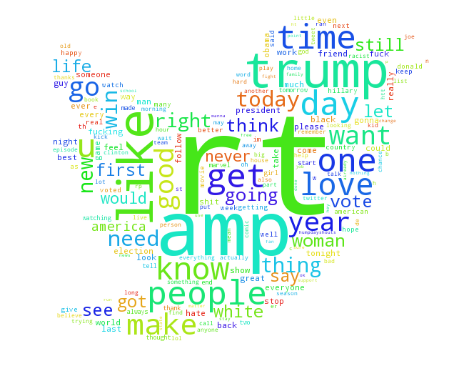

In [21]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


def draw_tag_cloud(out_slice):
    """Draws tag cloud of found tokens, you also need 'twitter_mask.png' in the same directory"""
    # your code here
    

    #
    twitter_mask = np.array(Image.open( "twitter_mask.png"))
    wc = WordCloud(background_color="white", mask=twitter_mask)
    wc.generate_from_frequencies(tok_freq(out_slice))
    plt.figure(figsize = (16, 6))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

draw_tag_cloud(out_slice)